Recurrent Neural Networks (RNN)
====================



In this notebook I tried to explore the usage of RNNs and LSTM in pytorch. I have written personal implementations of the cells (granted, still using pytorch operations), then I timed then against the standard pytorch implementations. I explored the vanishing gradient issue in RNN's by plotting the gradient norms vs time, then empirically showed that the gradients improve in magnitude when using LSTM. Finally, a simple LSTM net is used for image classificication, where input at time t is row of image at time t. The classifier works surprisingly well on 





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import platform
print('Using python: ', platform.python_version())
print('Using torch version: ', torch.__version__)
print('Using device: ', device)


Using python:  3.7.3
Using torch version:  1.1.0
Using device:  cpu


In [4]:

from rnn_nn import RNN

Luckily, Pytorch already has implemented a simple RNN in their library and you can call the RNN with <code>nn.RNN</code>. We will use the Pytorch RNN function to check if we have built the correct cell and compare the output of both functions. We also compare the running time of both classes.

In [6]:
import torch.nn as nn
import timeit

# choose your network parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_rnn=nn.RNN(input_size, hidden_dim)
i2dl_rnn=RNN(input_size, hidden_dim)

# initialise both rnn with same values
for p in pytorch_rnn.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_rnn.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 1, input_size)

output_pytorch, h_pytorch = pytorch_rnn(X)
output_i2dl, h_i2dl = i2dl_rnn(X)


# The difference of outputs should be 0!!

diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("all good")
else:
    print("whoopsie")

Differnce between pytorch and RNN implementation: 0.0
all good


In [7]:
import timeit
runs=10**4

print("Time Pytorch RNN {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_rnn(X)", 
                                       setup="from __main__ import pytorch_rnn, X", 
                                       number=runs))
     )

print("Time I2DL RNN {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_rnn(X)", 
                                       setup="from __main__ import i2dl_rnn, X", 
                                       number=runs))
     )

Time Pytorch RNN 10000 runs: 2.456s
Time I2DL RNN 10000 run: 4.689s


We can see that of course the pytorch implementation is faster :)

## Vanishing Gradient Exploration

This section shows thatthe effect of the past inputs to the final output vanishes with the distance in time. Plot of the gradients of input with respect to time

torch.Size([50, 1, 20])


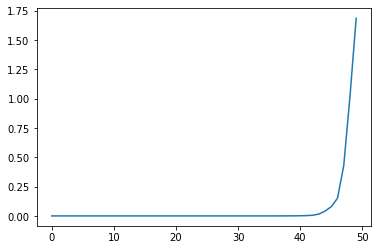

In [8]:

import torch
import torch.nn as nn

# create a random input of shape (batch,sequence,features)
no_features =20
hidden_size = 20
seq_len = 50
batch = 1

X = torch.ones(seq_len, batch, no_features,requires_grad=True)
#X = [Variable(i, requires_grad= True) for i in X ]
Y = torch.ones(seq_len, batch, no_features) *1.1

my_RNN = nn.RNN (20,20)
output, h_t = my_RNN(X) #output has shape:seq_len, batch,hidden_size


h = torch.sum(h_t)
h.backward()

#now we perform a backpropagation from each output
#grad_list = []
#print(loss.shape)

#print([ i for i in my_RNN.named_parameters()])
#print('debug.shape of X is %s'%str(X.shape))
# for t in range(seq_len):
#     my_RNN.zero_grad()
# 
#     #print(my_RNN.weight_ih_l0.grad)
#     #print(loss_t)
#     loss.backward(retain_graph=True)
#     grad_list.append(X[t].grad)
    #print(X[t].grad.shape)
    #print(my_RNN.all_weights)
    
#now stack the grad list, reduce using a meaningful metric..say l2 norm ,and plot
#print(grad_list)

# grad_list = torch.stack(grad_list)
# print('debug. grad_list shape is %s'%str(grad_list.shape))
# grad_list = torch.norm(grad_list,dim = (1,2)).detach().numpy()

print(X.grad.shape)
#now print grad list, should be a vector
plt.plot(torch.norm(X.grad.squeeze(),dim=1).detach().numpy())


## Long-Short Term Memory Network (LSTM)
We are exploring the LSTM cell, which is being able to learn from longer time sequences using two internal representations of data, the hidden state and the cell state. Also the cell can learn what to forget and what to keep using sigmoids. Again we time the implementations and compare the gradient vanish with the vanishing gradient of RNNs

In [10]:

from rnn_nn import LSTM

In [11]:
import torch.nn as nn

# choose input parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_lstm=nn.LSTM(input_size, hidden_dim)
i2dl_lstm=LSTM(input_size, hidden_dim)

# initialise both lstms with same values
for p in pytorch_lstm.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_lstm.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 1, input_size)

output_pytorch, (h_pytorch, _) = pytorch_lstm(X)
output_i2dl , (h_i2dl, _ )= i2dl_lstm(X)

# The difference of outputs should be 0!!
diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and your RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("all good")
else:
    print("whoopsie")

Differnce between pytorch and your RNN implementation: 0.0
all good


/home/tudor/Programs/anaconda3/envs/ML/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/tudor/Programs/anaconda3/envs/ML/lib/python3.7/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [12]:
import timeit
runs=10**4

print("Time Pytorch LSTM {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_lstm(X)", 
                                       setup="from __main__ import pytorch_lstm, X", 
                                       number=runs))
     )

print("Time I2DL LSTM {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_lstm(X)", 
                                       setup="from __main__ import i2dl_lstm, X", 
                                       number=runs))
     )

Time Pytorch LSTM 10000 runs: 5.534s
Time I2DL LSTM 10000 run: 19.020s


## Explore Gradients 



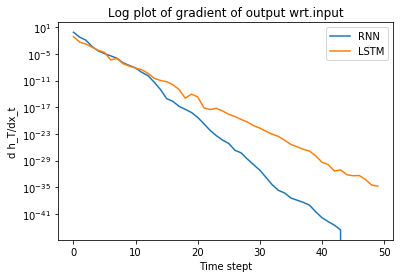

In [15]:
from rnn_nn import LSTM
from rnn_nn import RNN

input_size=1
hidden_dim=1
seq_len= 50

my_RNN=RNN(input_size, hidden_dim)
my_LSTM=LSTM(input_size, hidden_dim)



X1=torch.randn(seq_len, 1, input_size)
X2=torch.randn(seq_len, 1, input_size)
X1.requires_grad = True
X2.requires_grad = True

_,h_rnn = my_RNN(X1)
_,(h_lstm, c_lstm) = my_LSTM(X2)


h_rnn.backward()
h_lstm.backward()

#print('debug. Data about X. %s'%str(X))

plt.semilogy(np.flip(X1.grad.abs().squeeze().detach().numpy()),label = 'RNN')
plt.semilogy(np.flip(X2.grad.abs().squeeze().detach().numpy()), label = 'LSTM')
plt.legend()
plt.xlabel("Time stept")
plt.ylabel("d h_T/dx_t")
plt.title("Log plot of gradient of output wrt.input")  
plt.show()



## MNIST image classification with RNNs

using the mnist handwritten digits dataset, classifying using recurent nets, where each 'sentence' is a row of pixels



In [18]:
# Define data loader
from torchvision import transforms
import pickle

class Unsqueeze(object):
    """Adds a channel dimension that that our 2 dimensional input (H, W), 
    fits the 3 dimensional (H, W, C) expectations of pytorch's ToTensor function which
    expects a PIL image. This is very inefficient but you most probably will use pytorch's
    PIL image loader. Check out the documentation and make it more efficient :)
    """
    def __init__(self, dimension=0):
        self.dimension = dimension
    def __call__(self, numpy_array):
        extended_array = np.expand_dims(numpy_array, self.dimension)
        return extended_array
    def __repr__(self):
        return self.__class__.__name__ + 'dimension={}'.format(dimension)
    
class RemoveChannelDimension(object):
    """we have 1 channel, model assumes 1 channel and no extra dimension, hence squeeze the data"""
    def __call__(self,tensor):
        #print("debugg, remove channel was called")
        #print('shape of tensor: %s'%str(tensor.shape))
        tensor.squeeze(dim =0)
        #print('shape of tensor:after squeezing %s'%str(tensor.shape))
        return tensor
    

    
# transformation of data
transform = transforms.Compose([
    Unsqueeze(dimension=3),     
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    RemoveChannelDimension()
])


class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, 
                 transform=None):
        super(MnistDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
       
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform: 
            image = self.transform(image)
        return image, label

    
# loading the train data
with open("datasets/mnist_train.p", "rb") as f:
    mnist_raw = pickle.load(f)

X, y= mnist_raw
  

train_split = 0.8


train_dset=MnistDataset(X[:int(len(X)*train_split)], y[:int(len(X)*train_split)], transform=transform)
val_dset=MnistDataset(X[int(len(X)*train_split):], y[int(len(X)*train_split):], transform=transform)


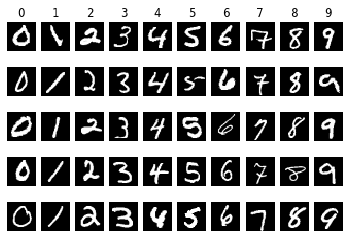

In [19]:
# Visualize some examples from the dataset. Stolen from other notebooks

X=train_dset.images
y=train_dset.labels


classes = list(range(10))
num_classes = len(classes)
samples_per_class = 5
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(train_dset.labels == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [21]:
from rnn_nn import LSTM_Classifier, RNN_Classifier



In [23]:
from solver import Solver

In [24]:
model_rnn = RNN_Classifier()
batch_size = 32
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dset,
                 batch_size=batch_size,
                 shuffle=True)
val_loader = torch.utils.data.DataLoader(
                dataset=val_dset,
                batch_size=batch_size,
                shuffle=False)

custom_adam_options = {
    "lr": 1e-2
}
solver = Solver(optim_args={"lr": 1e-3})

# train rnn model
solver.train(model_rnn, train_loader, val_loader, log_nth=50, num_epochs=4)

START TRAIN.


/home/tudor/Programs/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


[Iteration 50/6000] TRAIN loss: 2.263
[Iteration 100/6000] TRAIN loss: 2.124
[Iteration 150/6000] TRAIN loss: 1.952
[Iteration 200/6000] TRAIN loss: 1.898
[Iteration 250/6000] TRAIN loss: 1.804
[Iteration 300/6000] TRAIN loss: 1.708
[Iteration 350/6000] TRAIN loss: 1.635
[Iteration 400/6000] TRAIN loss: 1.569
[Iteration 450/6000] TRAIN loss: 1.821
[Iteration 500/6000] TRAIN loss: 1.521
[Iteration 550/6000] TRAIN loss: 1.458
[Iteration 600/6000] TRAIN loss: 1.519
[Iteration 650/6000] TRAIN loss: 1.448
[Iteration 700/6000] TRAIN loss: 1.553
[Iteration 750/6000] TRAIN loss: 1.449
[Iteration 800/6000] TRAIN loss: 1.456
[Iteration 850/6000] TRAIN loss: 1.405
[Iteration 900/6000] TRAIN loss: 1.409
[Iteration 950/6000] TRAIN loss: 1.445
[Iteration 1000/6000] TRAIN loss: 1.470
[Iteration 1050/6000] TRAIN loss: 1.469
[Iteration 1100/6000] TRAIN loss: 1.438
[Iteration 1150/6000] TRAIN loss: 1.454
[Iteration 1200/6000] TRAIN loss: 1.505
[Iteration 1250/6000] TRAIN loss: 1.376
[Iteration 1300/6000

Trying to improve the model by using a LSTM.

In [23]:
from exercise_code.rnn.rnn_nn import LSTM_Classifier
model= LSTM_Classifier()

batch_size = 32
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dset,
                 batch_size=batch_size,
                 shuffle=True)
val_loader = torch.utils.data.DataLoader(
                dataset=val_dset,
                batch_size=batch_size,
                shuffle=False)

custom_adam_options = {
    "lr": 1e-2
}
solver = Solver(optim_args={"lr": 1e-3})

# train rnn model
solver.train(model, train_loader, val_loader, log_nth=100, num_epochs=10)

START TRAIN.
[Iteration 100/15000] TRAIN loss: 2.095
[Iteration 200/15000] TRAIN loss: 1.553
[Iteration 300/15000] TRAIN loss: 1.320
[Iteration 400/15000] TRAIN loss: 1.235
[Iteration 500/15000] TRAIN loss: 1.070
[Iteration 600/15000] TRAIN loss: 0.917
[Iteration 700/15000] TRAIN loss: 0.915
[Iteration 800/15000] TRAIN loss: 0.739
[Iteration 900/15000] TRAIN loss: 0.458
[Iteration 1000/15000] TRAIN loss: 0.432
[Iteration 1100/15000] TRAIN loss: 0.361
[Iteration 1200/15000] TRAIN loss: 0.243
[Iteration 1300/15000] TRAIN loss: 0.212
[Iteration 1400/15000] TRAIN loss: 0.164
[Iteration 1500/15000] TRAIN loss: 0.148
[Epoch 1/10] TRAIN acc/loss: 0.812/0.148
[Epoch 1/10] VAL   acc/loss: 0.958/0.149
[Iteration 1600/15000] TRAIN loss: 0.148
[Iteration 1700/15000] TRAIN loss: 0.148
[Iteration 1800/15000] TRAIN loss: 0.123
[Iteration 1900/15000] TRAIN loss: 0.119
[Iteration 2000/15000] TRAIN loss: 0.136
[Iteration 2100/15000] TRAIN loss: 0.109
[Iteration 2200/15000] TRAIN loss: 0.131
[Iteration 2

/home/tudor/Programs/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
